<a href="https://colab.research.google.com/github/adityabaidya7/INFY_StockPricePrediction/blob/main/RNN_LSTM_copy2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== INFOSYS Stock Price Predictor ===
Enter a date (YYYY-MM-DD): 2025-03-22
Weekends are not trading days.
Enter a date (YYYY-MM-DD): 2025-03-25


[*********************100%***********************]  1 of 1 completed

Fetching data from Yahoo Finance...
Training RNN model...
Epoch 1/80


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0244 - val_loss: 0.0094
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 3/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 5/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0013 - val_loss: 0.0035
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 7/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0010 - val_loss: 0.0024
Epoch 9/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.3799e-04 - val_loss: 0.0020
Epoch 10/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.8536e-04 - val_loss: 0.0018
Epoch 11/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 8.4080e-04 - val_loss: 0.0016
Epoch 12/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 8.

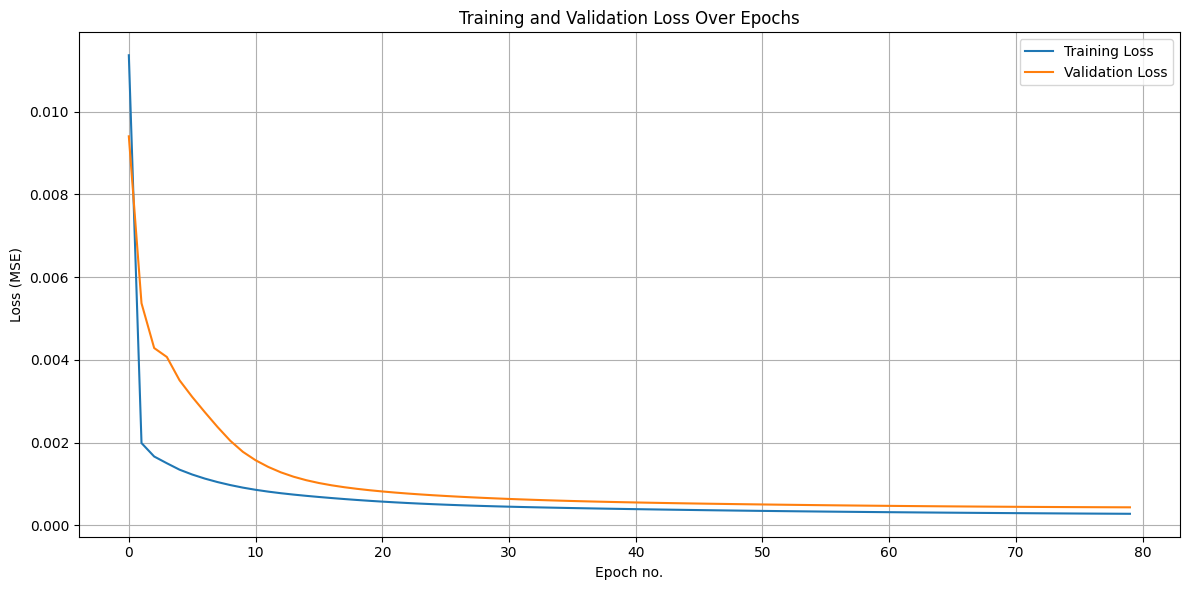


📊 Training Set Performance Metrics:
📉 Mean Absolute Error (MAE) : ₹17.47
📉 Mean Squared Error (MSE)  : ₹549.10
📉 Root Mean Squared Error   : ₹23.43
📈 R² Score                  : 0.9852

📊 Validation Set Performance Metrics:
📉 Mean Absolute Error (MAE) : ₹19.96
📉 Mean Squared Error (MSE)  : ₹806.69
📉 Root Mean Squared Error   : ₹28.40
📈 R² Score                  : 0.9678

📅 Prediction for 2025-03-25:
🔮 Predicted Closing Price: ₹1571.73
📈 Actual Closing Price   : ₹1605.8553466796875


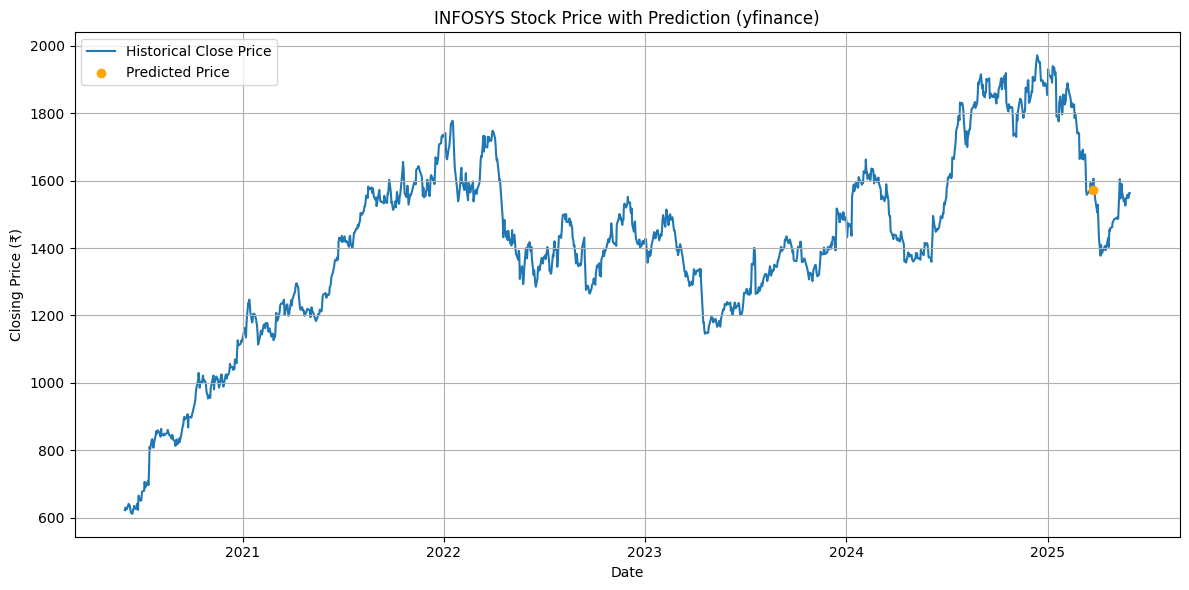

In [ ]:
from sklearn.model_selection import train_test_split

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
SYMBOL = "INFY.NS"
START_DATE = "2020-06-01"
END_DATE = "2025-05-31"
SEQUENCE_LENGTH = 60  # 60 days for input sequence

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

# Validate input date
def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2020, 6, 1) <= date <= datetime.date(2025, 5, 31)):
            print("Date not in allowed range.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Download historical stock data using yfinance
def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
    df = df[['Close']]
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

# Preprocess: Normalize data and create sequences
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_close)):
        X.append(scaled_close[i - SEQUENCE_LENGTH:i])
        y.append(scaled_close[i])

    X = np.array(X)
    y = np.array(y)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    return X_train, X_val, y_train, y_val, scaler, scaled_close

# Build the SimpleRNN model
def build_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Predict closing price for the given date
def predict_price(model, df, user_date, scaler, scaled_close):
    all_dates = df.index.date
    # Convert user_date to datetime.date for consistent comparison
    user_date_dt = user_date

    # Find the closest trading day if the requested date is not a trading day
    if user_date_dt not in all_dates:
        print(f"No trading data on {user_date_dt}. Predicting for previous valid trading day.")
        try:
            # Find the latest trading day before user_date
            date_used = max([d for d in all_dates if d < user_date_dt])
        except ValueError:
            # No trading data before the user date
            print("No sufficient historical data available before the entered date.")
            return None, None, user_date_dt
    else:
        date_used = user_date_dt # Use the exact user date if it's a trading day

    try:
        # Get the index position for the date used for prediction
        idx = list(df.index.date).index(date_used)
    except ValueError:
        # Should not happen if date_used is from df.index.date, but added for robustness
        print(f"Error finding index for date {date_used}.")
        return None, None, user_date_dt

    if idx < SEQUENCE_LENGTH:
        print("Not enough historical data to make a prediction.")
        return None, None, date_used

    # Prepare input sequence
    input_seq = scaled_close[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    # Predict scaled price
    predicted_scaled = model.predict(input_seq, verbose=0)
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    # Get the actual price for the date used for prediction
    # Ensure we handle potential Series output from .loc
    actual_price_series = df.loc[df.index.date == date_used, 'Close']
    actual_price = float(actual_price_series.iloc[0]) if not actual_price_series.empty else None

    return predicted_price, actual_price, date_used

# Plot the result
def plot_results(df, predicted_date, predicted_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    print("=== INFOSYS Stock Price Predictor ===")
    user_date = get_user_date()

    # Step 1: Load and prepare data
    df = get_stock_data()

    # Step 2: Preprocessing
    #X, y, scaler, scaled_close = preprocess_data(df)
    X_train, X_val, y_train, y_val, scaler, scaled_close = preprocess_data(df)
    # Step 3: Build and train the model
    model = build_model((X_train.shape[1], 1))
    print("Training RNN model...")
    #history = model.fit(X, y, epochs=80, batch_size=32, validation_split=0.2, verbose=1)
    history = model.fit(X_train, y_train, epochs=80, batch_size=32, validation_data=(X_val, y_val), verbose=1)

    ####
    plot_training_loss(history)

    # Predict on training data to evaluate performance
    y_train_pred_scaled = model.predict(X_train, verbose=0)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
    y_true = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Calculate metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae = mean_absolute_error(y_true, y_train_pred)
    mse = mean_squared_error(y_true, y_train_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_train_pred)

    # Print metrics
    print("\n📊 Training Set Performance Metrics:")
    print(f"📉 Mean Absolute Error (MAE) : ₹{mae:.2f}")
    print(f"📉 Mean Squared Error (MSE)  : ₹{mse:.2f}")
    print(f"📉 Root Mean Squared Error   : ₹{rmse:.2f}")
    print(f"📈 R² Score                  : {r2:.4f}")

    # Predict on validation set
    y_val_pred_scaled = model.predict(X_val, verbose=0)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Compute metrics
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

    mae_val = mean_absolute_error(y_val_true, y_val_pred)
    mse_val = mean_squared_error(y_val_true, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val_true, y_val_pred)

    print("\n📊 Validation Set Performance Metrics:")
    print(f"📉 Mean Absolute Error (MAE) : ₹{mae_val:.2f}")
    print(f"📉 Mean Squared Error (MSE)  : ₹{mse_val:.2f}")
    print(f"📉 Root Mean Squared Error   : ₹{rmse_val:.2f}")
    print(f"📈 R² Score                  : {r2_val:.4f}")

    # Step 4: Predict
    predicted_price, actual_price, date_used = predict_price(model, df, user_date, scaler, scaled_close)
    if predicted_price is not None: # Check if prediction was possible
        print(f"\n📅 Prediction for {date_used}:")
        print(f"🔮 Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None: # Check if actual price was found
            print(f"📈 Actual Closing Price   : ₹{actual_price}")
        else:
            print("⚠️ Actual price not available for this date.")

        # Step 5: Plot
        plot_results(df, date_used, predicted_price)
    else:
        print("❌ Unable to predict price due to insufficient data.")

if __name__ == "__main__":
    main()

=== INFOSYS Stock Price Predictor ===
Enter a date (YYYY-MM-DD): 2025-05-30
Fetching data from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


Training RNN model...
Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1523 - val_loss: 0.0119
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0020 - val_loss: 0.0069
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0010 - val_loss: 0.0043
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 9.0041e-04 - val_loss: 0.0034
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 8.5593e-04 - val_loss: 0.0031
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 8.1287e-04 - val_loss: 0.0029
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.7930e-04 - val_loss: 0.0026
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.5000e-04 - val_loss: 0.0024
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.2294e-04 - val_loss: 0.0023
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.9826e-04 - val_loss: 0.0021
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.7571e-04 - val_loss: 0.002

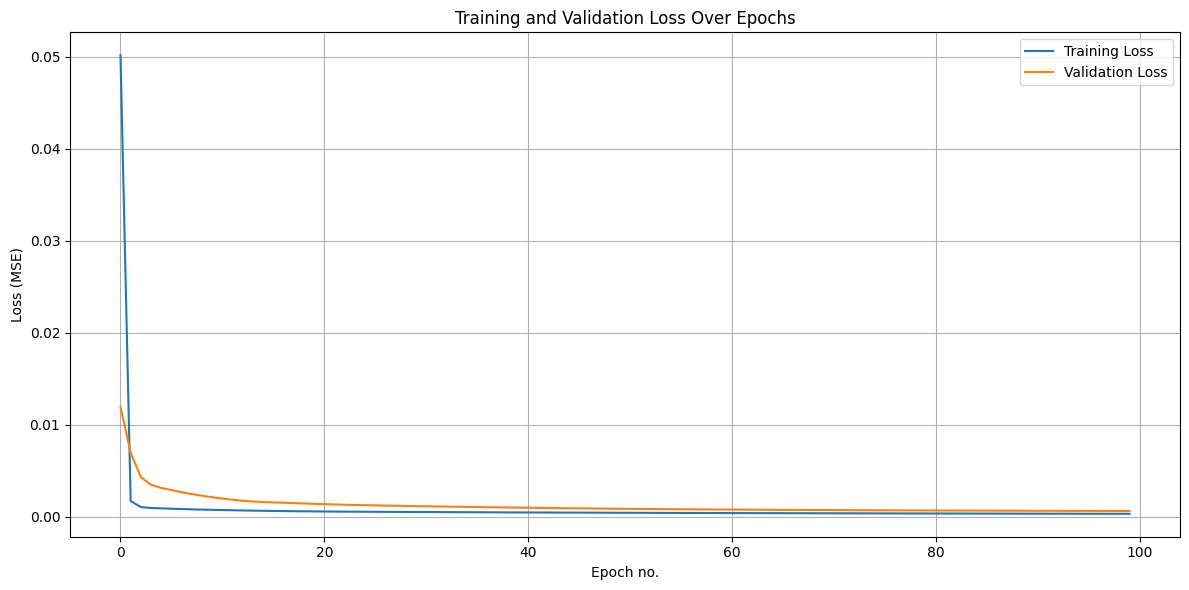


📊 Training Set Performance Metrics:
📉 Mean Absolute Error (MAE) : ₹18.59
📉 Mean Squared Error (MSE)  : ₹636.02
📉 Root Mean Squared Error   : ₹25.22
📈 R² Score                  : 0.9888

📅 Prediction for 2025-05-30:
🔮 Predicted Closing Price: ₹1551.20
📈 Actual Closing Price   : ₹1562.699951171875


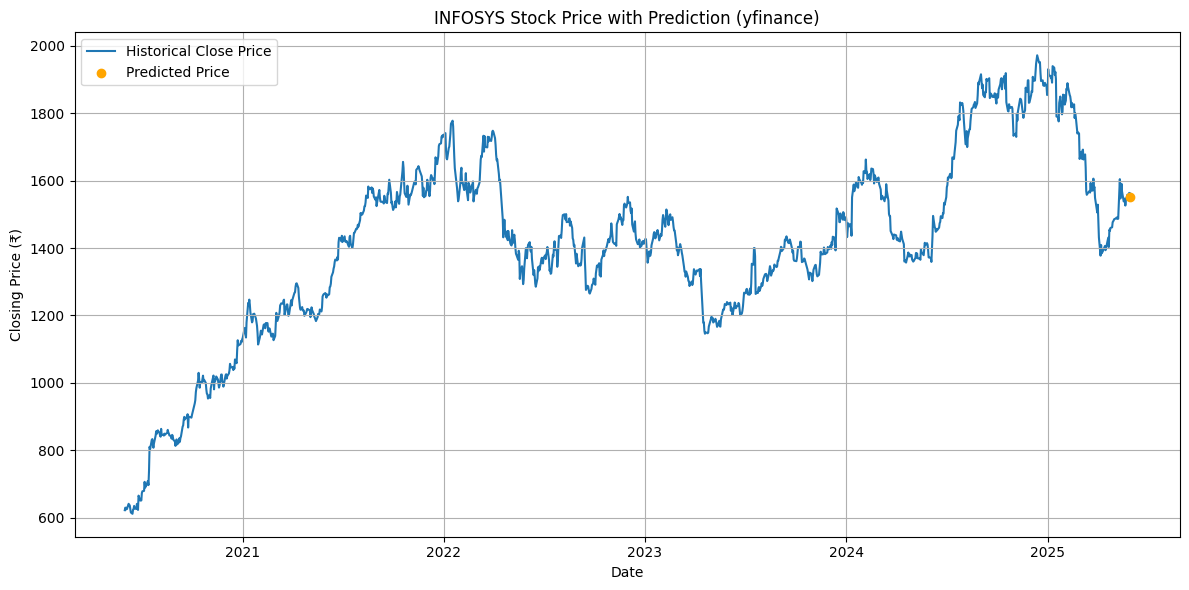

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
SYMBOL = "INFY.NS"
START_DATE = "2020-06-01"
END_DATE = "2025-05-31"
SEQUENCE_LENGTH = 60  # 60 days for input sequence

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

# Validate input date
def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2020, 6, 1) <= date <= datetime.date(2025, 5, 31)):
            print("Date not in allowed range.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Download historical stock data using yfinance
def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
    df = df[['Close']]
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

# Preprocess: Normalize data and create sequences
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_close)):
        X.append(scaled_close[i - SEQUENCE_LENGTH:i])
        y.append(scaled_close[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler, scaled_close

# Build the SimpleRNN model
def build_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Predict closing price for the given date
def predict_price(model, df, user_date, scaler, scaled_close):
    all_dates = df.index.date
    # Convert user_date to datetime.date for consistent comparison
    user_date_dt = user_date

    # Find the closest trading day if the requested date is not a trading day
    if user_date_dt not in all_dates:
        print(f"No trading data on {user_date_dt}. Predicting for previous valid trading day.")
        try:
            # Find the latest trading day before user_date
            date_used = max([d for d in all_dates if d < user_date_dt])
        except ValueError:
            # No trading data before the user date
            print("No sufficient historical data available before the entered date.")
            return None, None, user_date_dt
    else:
        date_used = user_date_dt # Use the exact user date if it's a trading day

    try:
        # Get the index position for the date used for prediction
        idx = list(df.index.date).index(date_used)
    except ValueError:
        # Should not happen if date_used is from df.index.date, but added for robustness
        print(f"Error finding index for date {date_used}.")
        return None, None, user_date_dt

    if idx < SEQUENCE_LENGTH:
        print("Not enough historical data to make a prediction.")
        return None, None, date_used

    # Prepare input sequence
    input_seq = scaled_close[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    # Predict scaled price
    predicted_scaled = model.predict(input_seq, verbose=0)
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    # Get the actual price for the date used for prediction
    # Ensure we handle potential Series output from .loc
    actual_price_series = df.loc[df.index.date == date_used, 'Close']
    actual_price = float(actual_price_series.iloc[0]) if not actual_price_series.empty else None

    return predicted_price, actual_price, date_used

# Plot the result
def plot_results(df, predicted_date, predicted_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs (SimpleRNN)")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    print("=== INFOSYS Stock Price Predictor ===")
    user_date = get_user_date()

    # Step 1: Load and prepare data
    df = get_stock_data()

    # Step 2: Preprocessing
    X, y, scaler, scaled_close = preprocess_data(df)

    # Step 3: Build and train the model
    model = build_model((X.shape[1], 1))
    print("Training RNN model...")
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

    ####
    plot_training_loss(history)

    # Predict on training data to evaluate performance
    y_train_pred_scaled = model.predict(X, verbose=0)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
    y_true = scaler.inverse_transform(y.reshape(-1, 1))

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_train_pred)
    mse = mean_squared_error(y_true, y_train_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_train_pred)

    # Print metrics
    print("\n📊 Training Set Performance Metrics (SimpleRNN):")
    print(f"📉 Mean Absolute Error (MAE) : ₹{mae:.2f}")
    print(f"📉 Mean Squared Error (MSE)  : ₹{mse:.2f}")
    print(f"📉 Root Mean Squared Error   : ₹{rmse:.2f}")
    print(f"📈 R² Score                  : {r2:.4f}")

    # Step 4: Predict
    predicted_price, actual_price, date_used = predict_price(model, df, user_date, scaler, scaled_close)
    if predicted_price is not None: # Check if prediction was possible
        print(f"\n📅 Prediction for {date_used}:")
        print(f"🔮 Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None: # Check if actual price was found
            print(f"📈 Actual Closing Price   : ₹{actual_price}")
        else:
            print("⚠️ Actual price not available for this date.")

        # Step 5: Plot
        plot_results(df, date_used, predicted_price)
    else:
        print("❌ Unable to predict price due to insufficient data.")

if __name__ == "__main__":
    main()

=== INFOSYS Stock Price Predictor ===
Enter a date (YYYY-MM-DD): 2025-03-21
Fetching data from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


Training RNN model...
Epoch 1/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0255 - val_loss: 0.0128
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0014 - val_loss: 0.0055
Epoch 3/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.3967e-04 - val_loss: 0.0037
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 8.2408e-04 - val_loss: 0.0033
Epoch 5/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 7.4728e-04 - val_loss: 0.0029
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.8888e-04 - val_loss: 0.0027
Epoch 7/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.4683e-04 - val_loss: 0.0026
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.1074e-04 - val_loss: 0.0022
Epoch 9/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.7302e-04 - val_loss: 0.0017
Epoch 10/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.4672e-04 - val_loss: 0.0015
Epoch 11/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3113e-04 - val_loss: 0.0013
Epoch

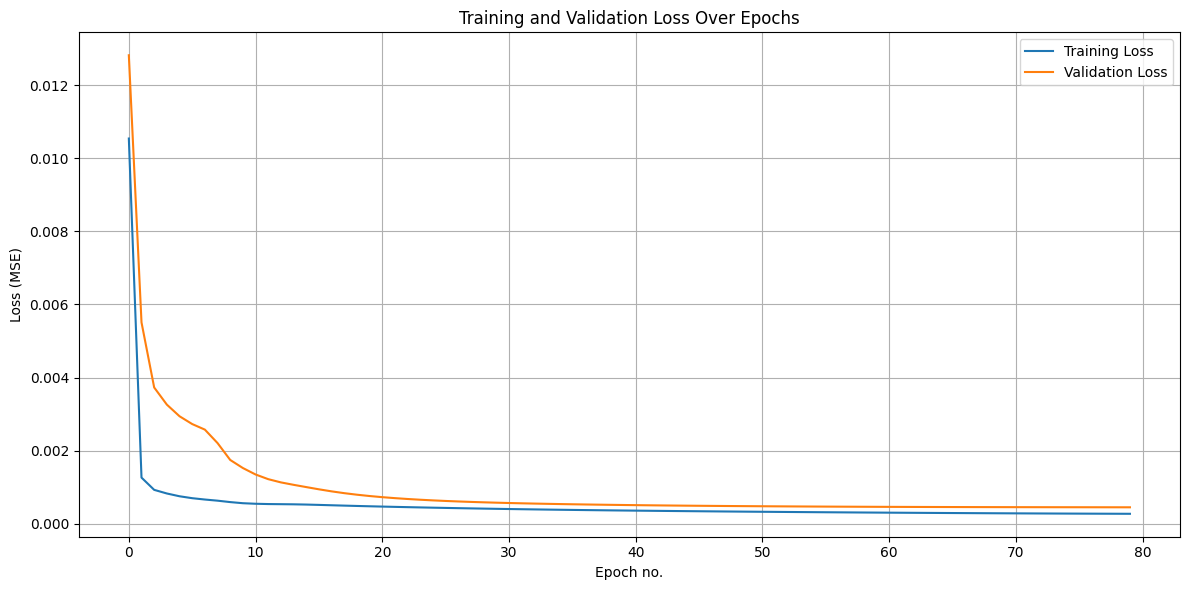


📊 Training Set Performance Metrics:
📉 Mean Absolute Error (MAE) : ₹17.40
📉 Mean Squared Error (MSE)  : ₹565.20
📉 Root Mean Squared Error   : ₹23.77
📈 R² Score                  : 0.9899

📅 Prediction for 2025-03-21:
🔮 Predicted Closing Price: ₹1594.06
📈 Actual Closing Price   : ₹1570.45361328125


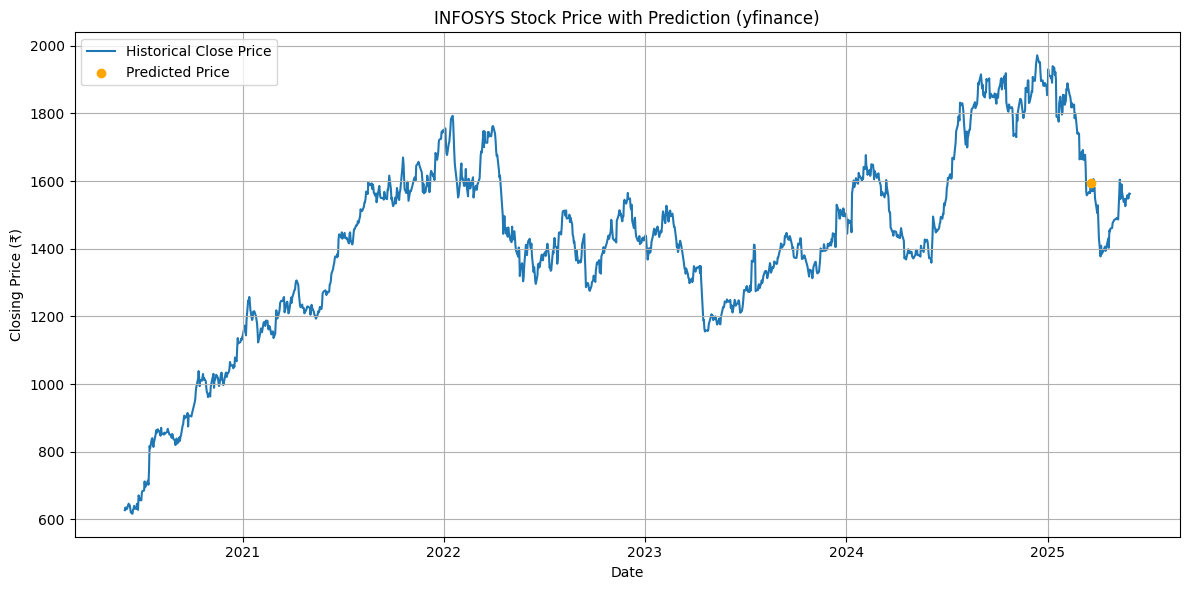

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
SYMBOL = "INFY.NS"
START_DATE = "2020-06-01"
END_DATE = "2025-05-31"
SEQUENCE_LENGTH = 60  # 60 days for input sequence

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

# Validate input date
def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2020, 6, 1) <= date <= datetime.date(2025, 5, 31)):
            print("Date not in allowed range.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Download historical stock data using yfinance
def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
    df = df[['Close']]
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

# Preprocess: Normalize data and create sequences
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_close)):
        X.append(scaled_close[i - SEQUENCE_LENGTH:i])
        y.append(scaled_close[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler, scaled_close

# Build the SimpleRNN model
def build_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Predict closing price for the given date
def predict_price(model, df, user_date, scaler, scaled_close):
    all_dates = df.index.date
    # Convert user_date to datetime.date for consistent comparison
    user_date_dt = user_date

    # Find the closest trading day if the requested date is not a trading day
    if user_date_dt not in all_dates:
        print(f"No trading data on {user_date_dt}. Predicting for previous valid trading day.")
        try:
            # Find the latest trading day before user_date
            date_used = max([d for d in all_dates if d < user_date_dt])
        except ValueError:
            # No trading data before the user date
            print("No sufficient historical data available before the entered date.")
            return None, None, user_date_dt
    else:
        date_used = user_date_dt # Use the exact user date if it's a trading day

    try:
        # Get the index position for the date used for prediction
        idx = list(df.index.date).index(date_used)
    except ValueError:
        # Should not happen if date_used is from df.index.date, but added for robustness
        print(f"Error finding index for date {date_used}.")
        return None, None, user_date_dt

    if idx < SEQUENCE_LENGTH:
        print("Not enough historical data to make a prediction.")
        return None, None, date_used

    # Prepare input sequence
    input_seq = scaled_close[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    # Predict scaled price
    predicted_scaled = model.predict(input_seq, verbose=0)
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    # Get the actual price for the date used for prediction
    # Ensure we handle potential Series output from .loc
    actual_price_series = df.loc[df.index.date == date_used, 'Close']
    actual_price = float(actual_price_series.iloc[0]) if not actual_price_series.empty else None

    return predicted_price, actual_price, date_used

# Plot the result
def plot_results(df, predicted_date, predicted_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    print("=== INFOSYS Stock Price Predictor ===")
    user_date = get_user_date()

    # Step 1: Load and prepare data
    df = get_stock_data()

    # Step 2: Preprocessing
    X, y, scaler, scaled_close = preprocess_data(df)

    # Step 3: Build and train the model
    model = build_model((X.shape[1], 1))
    print("Training RNN model...")
    history = model.fit(X, y, epochs=80, batch_size=32, validation_split=0.2, verbose=1)

    ####
    plot_training_loss(history)

    # Predict on training data to evaluate performance
    y_train_pred_scaled = model.predict(X, verbose=0)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
    y_true = scaler.inverse_transform(y.reshape(-1, 1))

    # Calculate metrics
    mae = mean_absolute_error(y_true, y_train_pred)
    mse = mean_squared_error(y_true, y_train_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_train_pred)

    # Print metrics
    print("\n📊 Training Set Performance Metrics:")
    print(f"📉 Mean Absolute Error (MAE) : ₹{mae:.2f}")
    print(f"📉 Mean Squared Error (MSE)  : ₹{mse:.2f}")
    print(f"📉 Root Mean Squared Error   : ₹{rmse:.2f}")
    print(f"📈 R² Score                  : {r2:.4f}")

    # Step 4: Predict
    predicted_price, actual_price, date_used = predict_price(model, df, user_date, scaler, scaled_close)
    if predicted_price is not None: # Check if prediction was possible
        print(f"\n📅 Prediction for {date_used}:")
        print(f"🔮 Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None: # Check if actual price was found
            print(f"📈 Actual Closing Price   : ₹{actual_price}")
        else:
            print("⚠️ Actual price not available for this date.")

        # Step 5: Plot
        plot_results(df, date_used, predicted_price)
    else:
        print("❌ Unable to predict price due to insufficient data.")

if __name__ == "__main__":
    main()

=== INFOSYS Stock Price Predictor ===
Enter a date (YYYY-MM-DD): 2025-04-21


[*********************100%***********************]  1 of 1 completed

Fetching data from Yahoo Finance...
Training RNN model...
Epoch 1/100


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0579 - val_loss: 0.0024
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.5464e-04 - val_loss: 0.0021
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 6.1473e-04 - val_loss: 0.0021
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.6225e-04 - val_loss: 0.0020
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.2751e-04 - val_loss: 0.0019
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.9892e-04 - val_loss: 0.0017
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.7424e-04 - val_loss: 0.0015
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 4.5323e-04 - val_loss: 0.0014
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.3688e-04 - val_loss: 0.0013
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.2367e-04 - val_loss: 0.0012
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 4.1248e-04 - val_loss: 0.0011
Epoch 12/100
30/30 ━━━━━

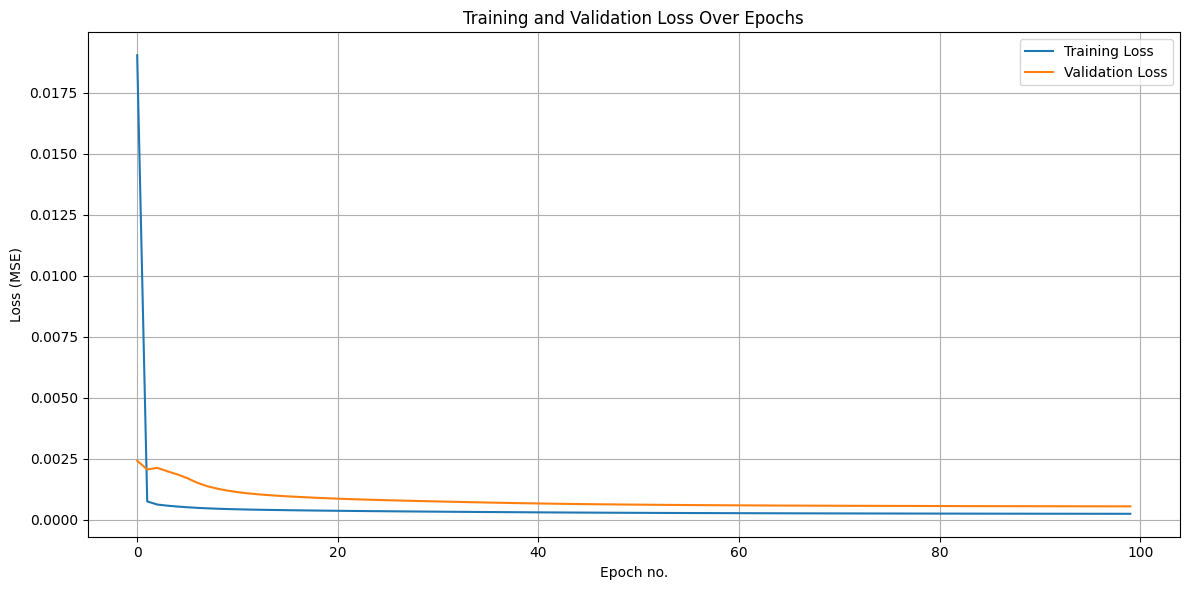


📅 Prediction for 2025-04-21:
🔮 Predicted Closing Price: ₹1399.36
📈 Actual Closing Price   : ₹1430.8675537109375


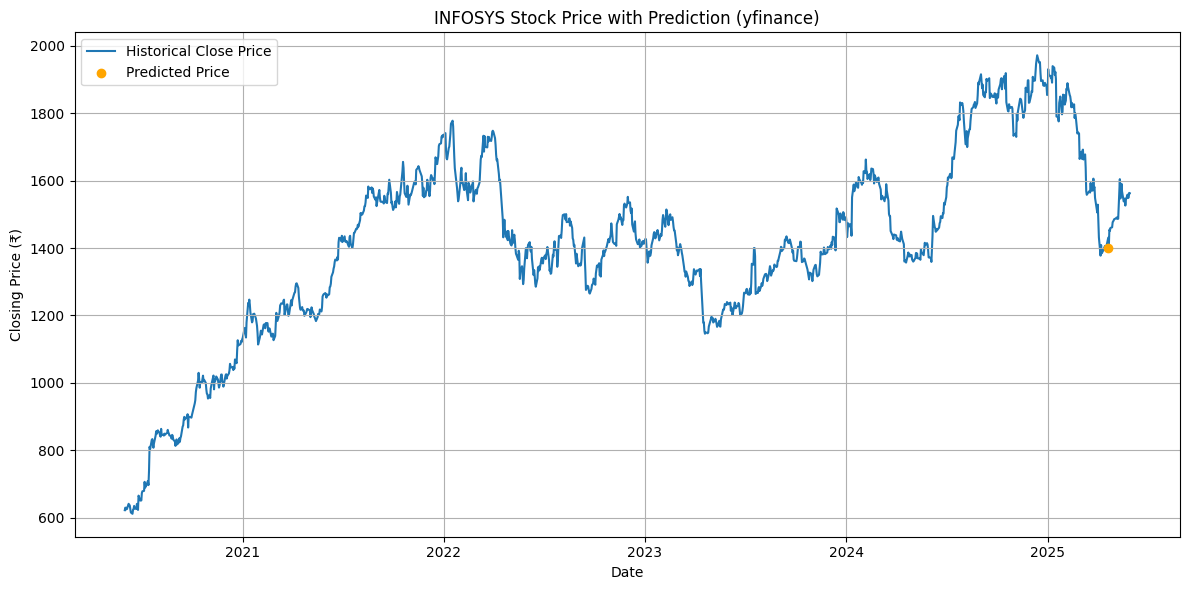

In [ ]:
# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
SYMBOL = "INFY.NS"
START_DATE = "2020-06-01"
END_DATE = "2025-05-31"
SEQUENCE_LENGTH = 60  # 60 days for input sequence

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

# Validate input date
def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2020, 6, 1) <= date <= datetime.date(2025, 5, 31)):
            print("Date not in allowed range.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Download historical stock data using yfinance
def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    df = yf.download(SYMBOL, start=START_DATE, end=END_DATE)
    df = df[['Close']]
    df.dropna(inplace=True)
    df.index = pd.to_datetime(df.index)
    return df

# Preprocess: Normalize data and create sequences
def preprocess_data(df):
    scaler = MinMaxScaler()
    scaled_close = scaler.fit_transform(df[['Close']])

    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_close)):
        X.append(scaled_close[i - SEQUENCE_LENGTH:i])
        y.append(scaled_close[i])

    X = np.array(X)
    y = np.array(y)
    return X, y, scaler, scaled_close

# Build the SimpleRNN model
def build_model(input_shape):
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Predict closing price for the given date
def predict_price(model, df, user_date, scaler, scaled_close):
    all_dates = df.index.date
    # Convert user_date to datetime.date for consistent comparison
    user_date_dt = user_date

    # Find the closest trading day if the requested date is not a trading day
    if user_date_dt not in all_dates:
        print(f"No trading data on {user_date_dt}. Predicting for previous valid trading day.")
        try:
            # Find the latest trading day before user_date
            date_used = max([d for d in all_dates if d < user_date_dt])
        except ValueError:
            # No trading data before the user date
            print("No sufficient historical data available before the entered date.")
            return None, None, user_date_dt
    else:
        date_used = user_date_dt # Use the exact user date if it's a trading day

    try:
        # Get the index position for the date used for prediction
        idx = list(df.index.date).index(date_used)
    except ValueError:
        # Should not happen if date_used is from df.index.date, but added for robustness
        print(f"Error finding index for date {date_used}.")
        return None, None, user_date_dt

    if idx < SEQUENCE_LENGTH:
        print("Not enough historical data to make a prediction.")
        return None, None, date_used

    # Prepare input sequence
    input_seq = scaled_close[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    # Predict scaled price
    predicted_scaled = model.predict(input_seq, verbose=0)
    # Inverse transform to get the actual price
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    # Get the actual price for the date used for prediction
    # Ensure we handle potential Series output from .loc
    actual_price_series = df.loc[df.index.date == date_used, 'Close']
    actual_price = float(actual_price_series.iloc[0]) if not actual_price_series.empty else None

    return predicted_price, actual_price, date_used

# Plot the result
def plot_results(df, predicted_date, predicted_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Main Function
def main():
    print("=== INFOSYS Stock Price Predictor ===")
    user_date = get_user_date()

    # Step 1: Load and prepare data
    df = get_stock_data()

    # Step 2: Preprocessing
    X, y, scaler, scaled_close = preprocess_data(df)

    # Step 3: Build and train the model
    model = build_model((X.shape[1], 1))
    print("Training RNN model...")
    history = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

    ####
    plot_training_loss(history)

    # Step 4: Predict
    predicted_price, actual_price, date_used = predict_price(model, df, user_date, scaler, scaled_close)
    if predicted_price is not None: # Check if prediction was possible
        print(f"\n📅 Prediction for {date_used}:")
        print(f"🔮 Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None: # Check if actual price was found
            print(f"📈 Actual Closing Price   : ₹{actual_price}")
        else:
            print("⚠️ Actual price not available for this date.")

        # Step 5: Plot
        plot_results(df, date_used, predicted_price)
    else:
        print("❌ Unable to predict price due to insufficient data.")

if __name__ == "__main__":
    main()